<a href="https://colab.research.google.com/github/MPGarg/Assignment-8/blob/main/EVA8_Assigment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
#!pip install -U albumentations
!pip install torch_lr_finder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch_lr_finder import LRFinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import files from GIT Hub

In [ ]:
!git clone https://github.com/MPGarg/main_repo.git

Cloning into 'main_repo'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 85 (delta 14), reused 0 (delta 0), pack-reused 52
Unpacking objects: 100% (85/85), 32.05 KiB | 482.00 KiB/s, done.


# Custom ResNet class is imported

In [ ]:
from main_repo.models import custom_resnet
from main_repo.models.custom_resnet import Custom_ResNet

# Import Other fuctions

In [ ]:
from main_repo import main, utils
from main_repo.utils import *    
from main_repo.main import train, test, fit_model

# Assign device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
view_model = Custom_ResNet().to(device)
summary(view_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
         Dropout2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
        Dropout2d-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Show sample images and Load dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


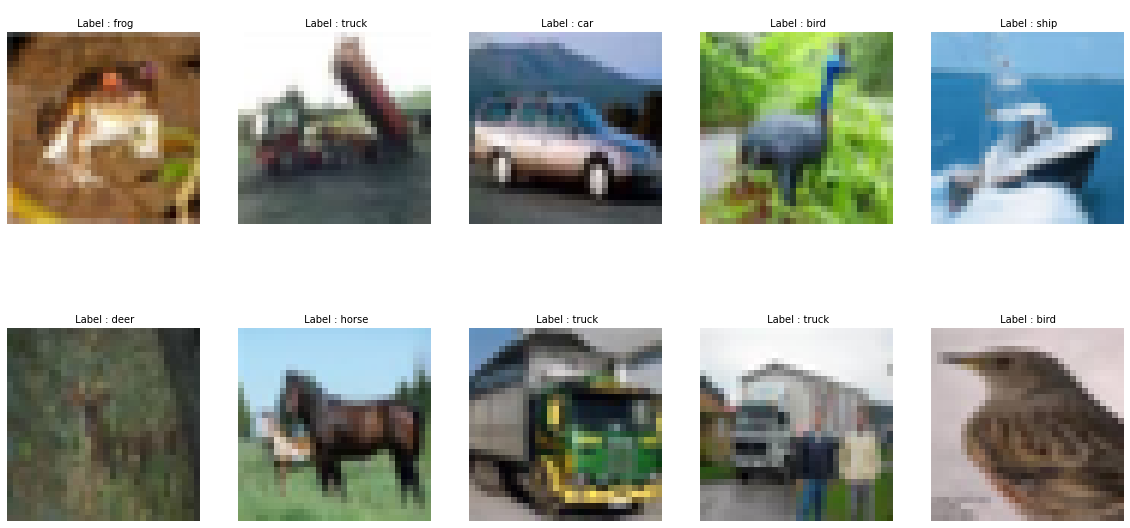

In [ ]:
trainset_mod, trainloader_mod, testset_mod, testloader_mod,mean, std = process_dataset(visualize = 'X')     

# Find Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.71E-01


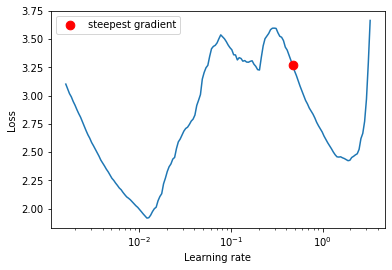

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7a5688fe80>, 0.4713753134116724)

In [38]:
import copy
model = Custom_ResNet(0.05).to(device)
model_exp = copy.deepcopy(model)
optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.001, momentum=0.9,weight_decay=0.005)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader_mod, end_lr=10, num_iter=200)
lr_finder.plot() 

In [39]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.012173827277396614


# Train & Test Model

In [40]:
optimizer = torch.optim.SGD(model.parameters(), lr=ler_rate/10, momentum=0.9,weight_decay=0.005)
#max_lr is the maximum learning rate of OneCycleLR 
#the learning rate will increase from max_lr / div_factor to max_lr in the first pct_start * total_steps steps, 
#and decrease smoothly to max_lr / final_div_factor then.
#total_steps = epochs * steps_per_epoch
#total_steps = 24 * 98 = 2,352
#max_lr / div_factor = 0.01 / 10 = 0.001
#pct_start * total_steps = 0.002 * 2,352 = 4.704
#max_lr / final_div_factor = 0.01 / 100 = 0.00001
#final_div_factor (float) – Determines the minimum learning rate via min_lr = initial_lr/final_div_factor

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader_mod), 
                                                epochs=24,
                                                pct_start=0.15,
                                                div_factor=10,
                                                three_phase=False, 
                                                #final_div_factor=1000,
                                                anneal_strategy='linear'
                                                ) 

model_tr, wrong_prediction_list, right_prediction_list, train_losses, train_acc, test_losses, test_acc = fit_model(
                                                    model=model, 
                                                    device=device,
                                                    trainloader=trainloader_mod, 
                                                    testloader=testloader_mod,
                                                    criterion = nn.CrossEntropyLoss(),
                                                    EPOCHS=24,
                                                    optimizer=optimizer,
                                                    scheduler=scheduler
                                                    
                                                )

EPOCH: 1 (LR: 0.0012173827277396614)


100%|██████████| 98/98 [00:28<00:00,  3.45it/s]


Average Training Loss=0.0036068648028373717, Accuracy=35.928


Test set: Average loss: 0.0026, Accuracy: 5311/10000 (53.11%)

EPOCH: 2 (LR: 0.004269490646632161)


100%|██████████| 98/98 [00:28<00:00,  3.44it/s]


Average Training Loss=0.0023923205387592315, Accuracy=56.382


Test set: Average loss: 0.0019, Accuracy: 6723/10000 (67.23%)

EPOCH: 3 (LR: 0.00732159856552466)


100%|██████████| 98/98 [00:28<00:00,  3.49it/s]


Average Training Loss=0.0019370749700069428, Accuracy=65.202


Test set: Average loss: 0.0017, Accuracy: 6984/10000 (69.84%)

EPOCH: 4 (LR: 0.010373706484417159)


100%|██████████| 98/98 [00:28<00:00,  3.47it/s]


Average Training Loss=0.0016193601965904237, Accuracy=71.118


Test set: Average loss: 0.0014, Accuracy: 7618/10000 (76.18%)

EPOCH: 5 (LR: 0.011929037880301387)


100%|██████████| 98/98 [00:28<00:00,  3.47it/s]


Average Training Loss=0.0013455870532989502, Accuracy=76.14


Test set: Average loss: 0.0011, Accuracy: 8038/10000 (80.38%)

EPOCH: 6 (LR: 0.011332287608775709)


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Average Training Loss=0.0011776592361927032, Accuracy=79.014


Test set: Average loss: 0.0010, Accuracy: 8265/10000 (82.65%)

EPOCH: 7 (LR: 0.01073553733725003)


100%|██████████| 98/98 [00:28<00:00,  3.46it/s]


Average Training Loss=0.0010532894760370256, Accuracy=81.334


Test set: Average loss: 0.0010, Accuracy: 8237/10000 (82.37%)

EPOCH: 8 (LR: 0.010138787065724351)


100%|██████████| 98/98 [00:28<00:00,  3.41it/s]


Average Training Loss=0.0009463917195796967, Accuracy=83.204


Test set: Average loss: 0.0009, Accuracy: 8378/10000 (83.78%)

EPOCH: 9 (LR: 0.009542036794198672)


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Average Training Loss=0.0008488984709978104, Accuracy=84.98


Test set: Average loss: 0.0009, Accuracy: 8463/10000 (84.63%)

EPOCH: 10 (LR: 0.008945286522672994)


100%|██████████| 98/98 [00:28<00:00,  3.44it/s]


Average Training Loss=0.0007622468972206116, Accuracy=86.516


Test set: Average loss: 0.0009, Accuracy: 8498/10000 (84.98%)

EPOCH: 11 (LR: 0.008348536251147315)


100%|██████████| 98/98 [00:28<00:00,  3.47it/s]


Average Training Loss=0.0007045518237352371, Accuracy=87.708


Test set: Average loss: 0.0008, Accuracy: 8674/10000 (86.74%)

EPOCH: 12 (LR: 0.007751785979621637)


100%|██████████| 98/98 [00:28<00:00,  3.46it/s]


Average Training Loss=0.000659494800567627, Accuracy=88.466


Test set: Average loss: 0.0007, Accuracy: 8765/10000 (87.65%)

EPOCH: 13 (LR: 0.007155035708095959)


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Average Training Loss=0.000609144975244999, Accuracy=89.288


Test set: Average loss: 0.0007, Accuracy: 8828/10000 (88.28%)

EPOCH: 14 (LR: 0.00655828543657028)


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Average Training Loss=0.0005793322747945786, Accuracy=90.024


Test set: Average loss: 0.0007, Accuracy: 8852/10000 (88.52%)

EPOCH: 15 (LR: 0.0059615351650446026)


100%|██████████| 98/98 [00:28<00:00,  3.45it/s]


Average Training Loss=0.0005336647987365723, Accuracy=90.846


Test set: Average loss: 0.0007, Accuracy: 8845/10000 (88.45%)

EPOCH: 16 (LR: 0.005364784893518923)


100%|██████████| 98/98 [00:27<00:00,  3.50it/s]


Average Training Loss=0.0004902093702554703, Accuracy=91.624


Test set: Average loss: 0.0006, Accuracy: 8921/10000 (89.21%)

EPOCH: 17 (LR: 0.004768034621993245)


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Average Training Loss=0.0004436550533771515, Accuracy=92.448


Test set: Average loss: 0.0006, Accuracy: 8939/10000 (89.39%)

EPOCH: 18 (LR: 0.004171284350467567)


100%|██████████| 98/98 [00:28<00:00,  3.49it/s]


Average Training Loss=0.00042333436876535417, Accuracy=92.916


Test set: Average loss: 0.0007, Accuracy: 8910/10000 (89.10%)

EPOCH: 19 (LR: 0.0035745340789418885)


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Average Training Loss=0.0003987117710709572, Accuracy=93.262


Test set: Average loss: 0.0006, Accuracy: 9000/10000 (90.00%)

EPOCH: 20 (LR: 0.0029777838074162098)


100%|██████████| 98/98 [00:28<00:00,  3.47it/s]


Average Training Loss=0.0003649986344575882, Accuracy=93.998


Test set: Average loss: 0.0006, Accuracy: 9026/10000 (90.26%)

EPOCH: 21 (LR: 0.0023810335358905328)


100%|██████████| 98/98 [00:28<00:00,  3.49it/s]


Average Training Loss=0.0003441233140230179, Accuracy=94.45


Test set: Average loss: 0.0006, Accuracy: 9043/10000 (90.43%)

EPOCH: 22 (LR: 0.0017842832643648523)


100%|██████████| 98/98 [00:28<00:00,  3.43it/s]


Average Training Loss=0.0003108303028345108, Accuracy=95.11


Test set: Average loss: 0.0005, Accuracy: 9075/10000 (90.75%)

EPOCH: 23 (LR: 0.0011875329928391735)


100%|██████████| 98/98 [00:28<00:00,  3.49it/s]


Average Training Loss=0.00028415188908576964, Accuracy=95.496


Test set: Average loss: 0.0005, Accuracy: 9106/10000 (91.06%)

EPOCH: 24 (LR: 0.0005907827213134965)


100%|██████████| 98/98 [00:28<00:00,  3.47it/s]


Average Training Loss=0.00025707389652729036, Accuracy=96.06


Test set: Average loss: 0.0005, Accuracy: 9137/10000 (91.37%)

Total Number of incorrectly predicted images by model is 863


# Display Validation Accuracy & Loss

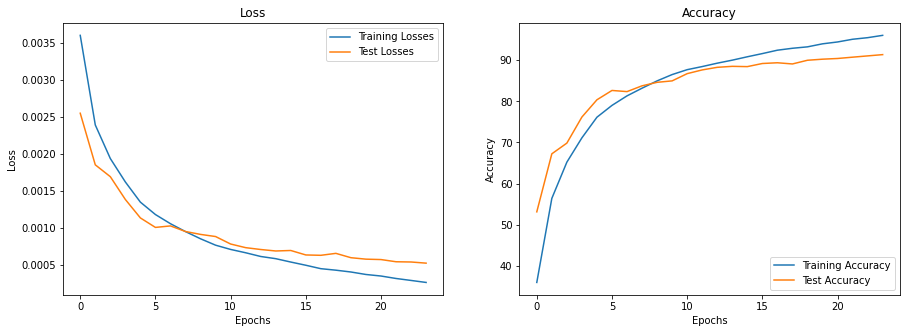

In [41]:
plot_acc_loss(train_acc,train_losses,test_acc,test_losses)

# Display wrong prediction

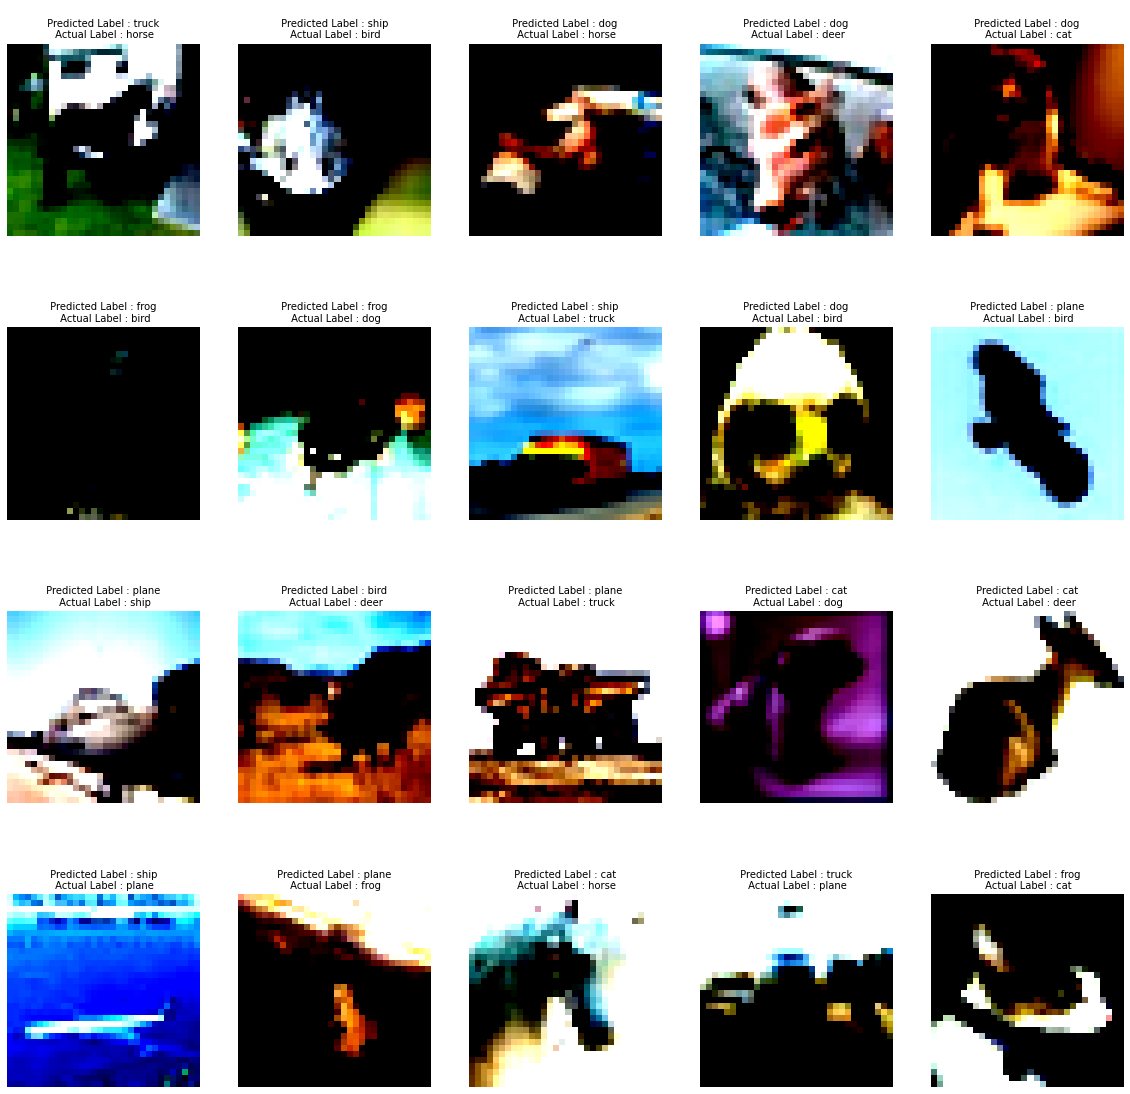

In [42]:
display_incorrect_pred(wrong_prediction_list)

# GradCam 

In [43]:
target_layers = ["layer1", "layer2","layer3"]
torch.autograd.set_detect_anomaly(True)

In [44]:
from main_repo.utils import generate_gradcam, plot_gradcam
gradcam_output, probs, predicted_classes = generate_gradcam(wrong_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


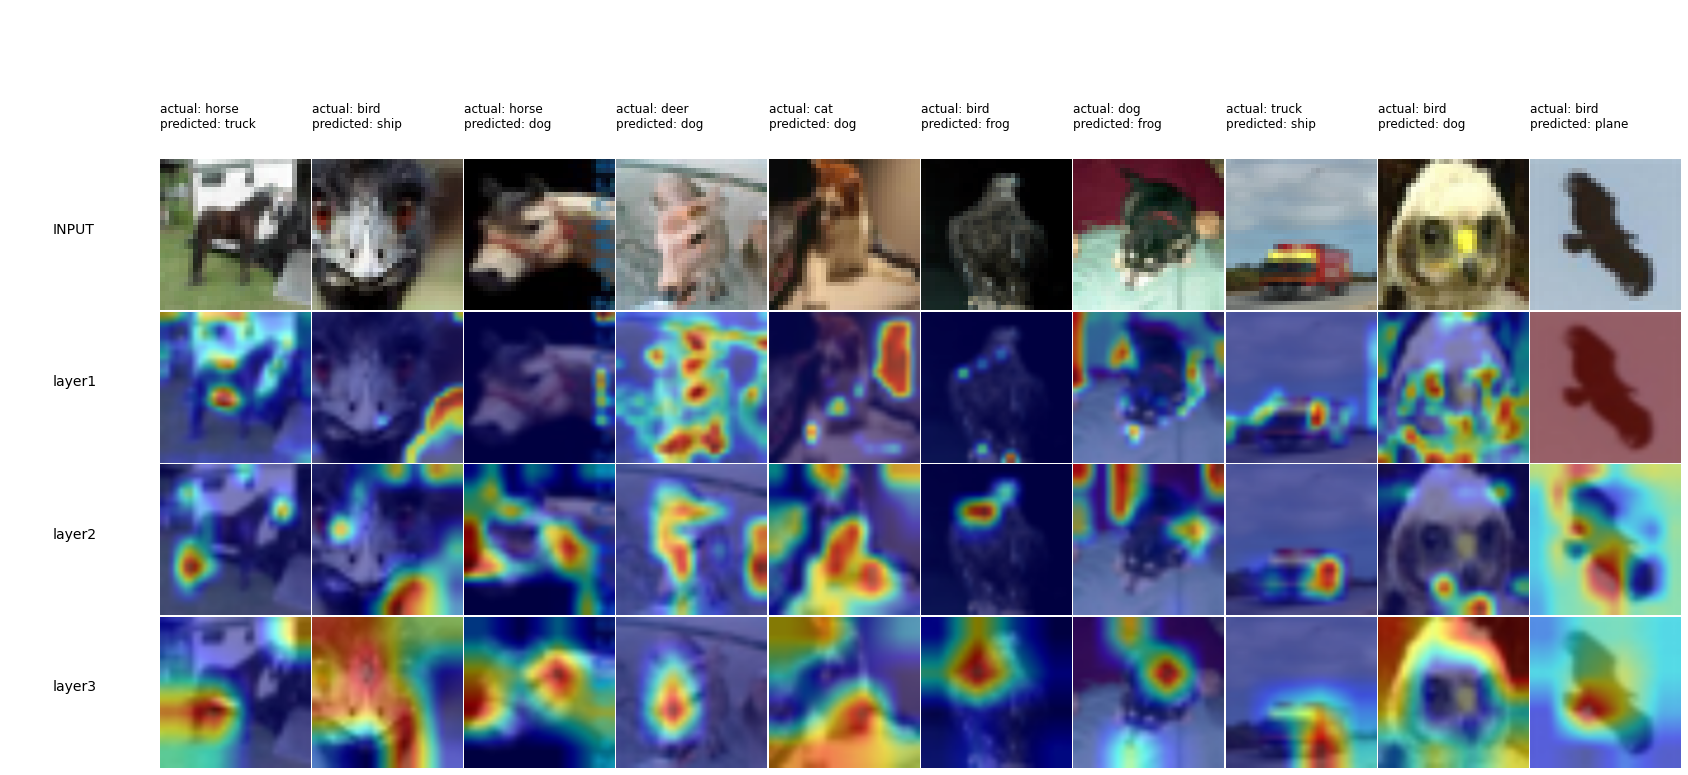

In [45]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, wrong_prediction_list[:10],mean,std)

In [46]:
gradcam_output, probs, predicted_classes = generate_gradcam(right_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


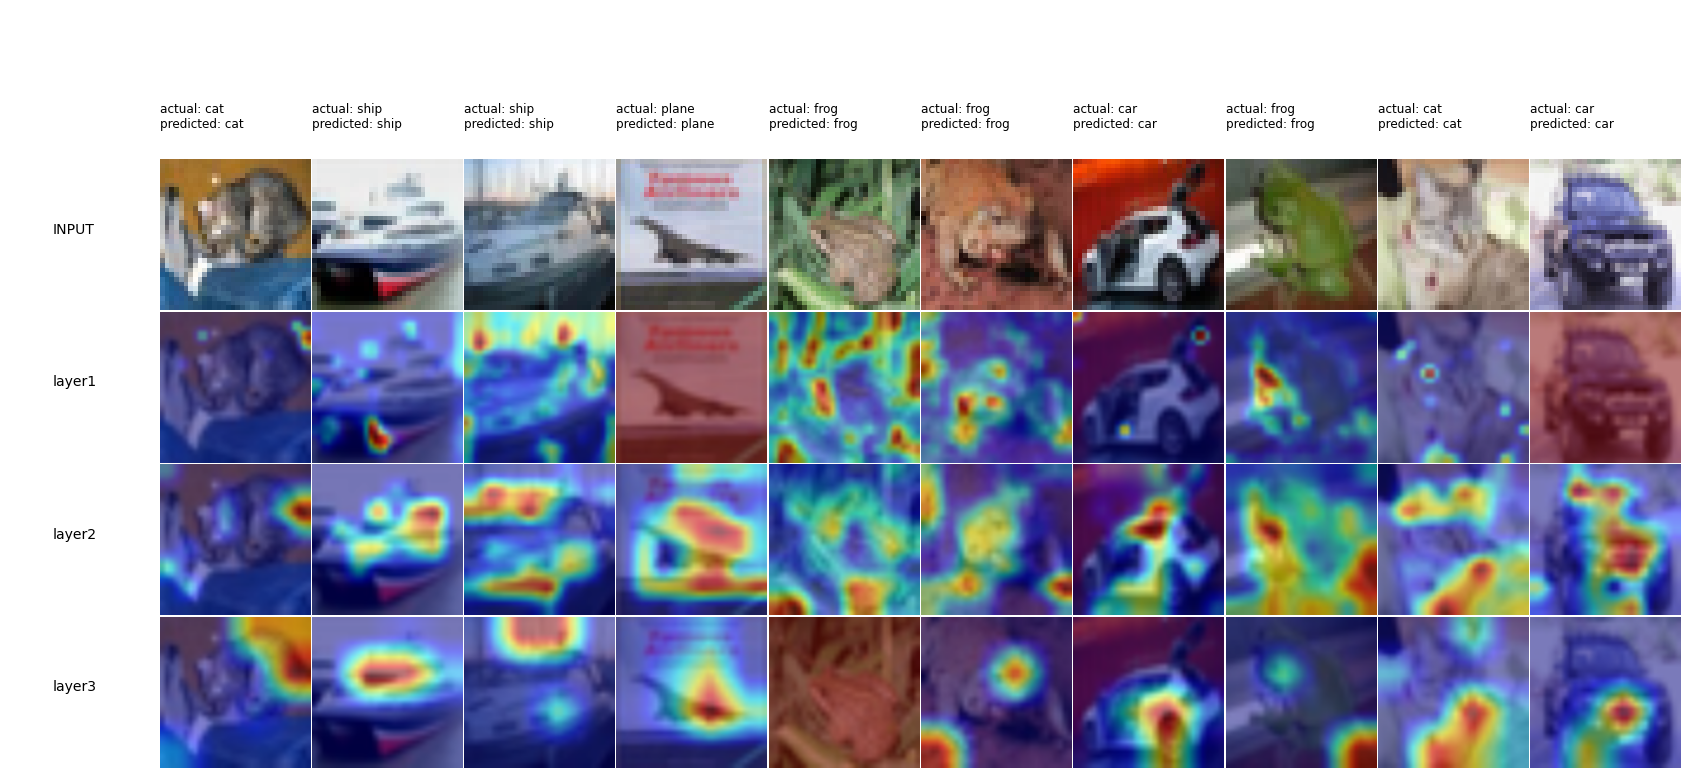

In [47]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, right_prediction_list[:10],mean,std)